In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
%matplotlib inline

## Pre-processing data

In [3]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
#Load and clean all raw data
from load_and_clean import *
us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population = load_clean('population')

In [5]:
#Filter data 
# This part might be to split and explain
from filter_data import *
rolling_average_duration = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )

#the last column of social distancing dataset is the last social distancing measure used by a location

social_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = create_rolling_data(all_data, rolling_average_duration)

all_data_cases = pd.concat([global_cases, uscases], axis=1) 
all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)

all_data_cases_daily = create_rolling_data(all_data_cases, rolling_average_duration)


newdf, intervention_date_us=filter_data_by_intervention(usdeaths, social_distancing)
newdf_global, intervention_date_global=filter_data_by_intervention(global_deaths, social_distancing)
newdf_uscounties, intervention_date_uscounties=filter_data_by_intervention(uscounties_deaths, social_distancing)

daily_global = create_rolling_data(newdf_global, rolling_average_duration)
daily_us = create_rolling_data(newdf, rolling_average_duration)
daily_uscounties = create_rolling_data(newdf_uscounties,rolling_average_duration)

cases_intervention_adjusted, intervention_date_case = filter_data_by_intervention(all_data_cases, social_distancing)
deaths_intervention_adjusted, intervention_date_death = filter_data_by_intervention(all_data, social_distancing)
deaths_intervention_adjusted_google, intervention_date_google =  filter_data_by_intervention(all_data, google_social)

cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration


last date
Exceptions are []


## Find the target areas by threshold values of deaths

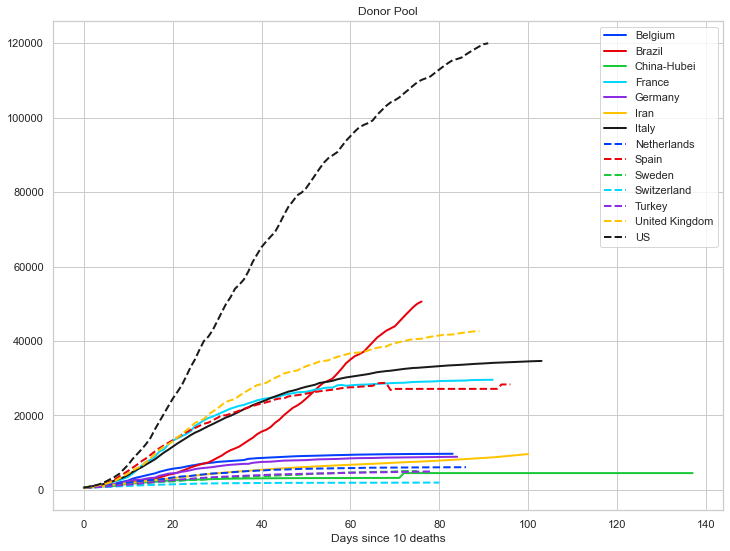

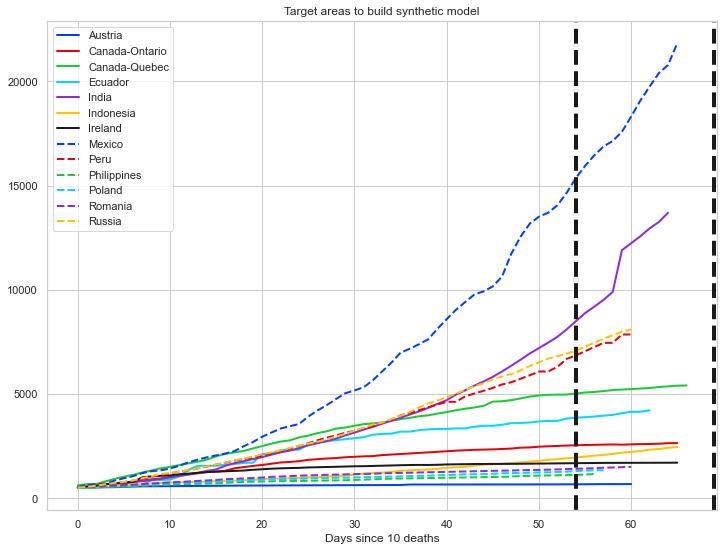

In [6]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})


sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)  
low_thresh=55
threshold=70
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)
plt.show()

## Apply synthetic control to New York - what if shutdown was carried out early

In [8]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]


for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,15):
        temp_df, date = filter_data_by_intervention(all_data_daily[[target]], social_distancing, i)

        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 60,22, "7-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12, 
                                   exclude=[target, 'China-Hubei'], animation = camera, showDonors=False, silent=True, showPlots=True, error_thresh=3)
    

    animation = camera.animate()

animation.save('New York new.mp4')
plt.close('all')
HTML(animation.to_html5_video())

## Apply synthetic control to reopen states - what if the states have not been reopened?

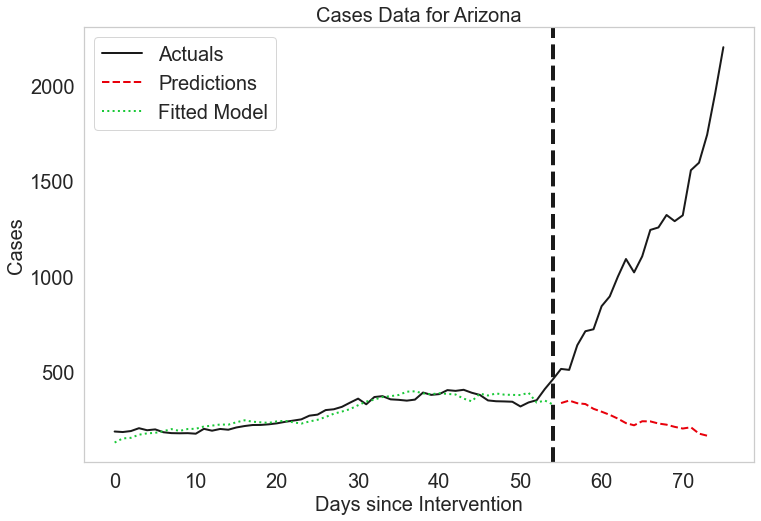

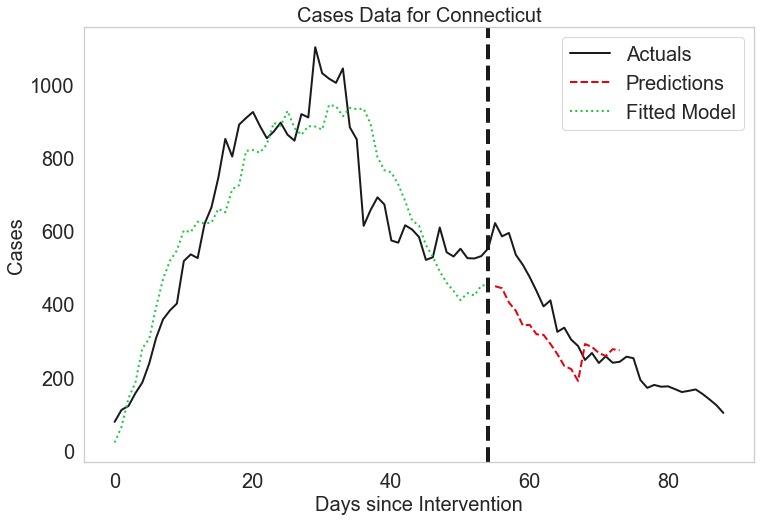

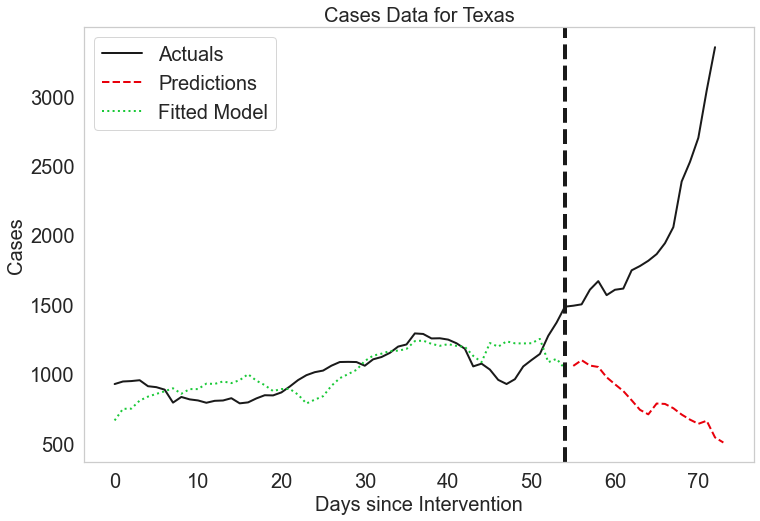

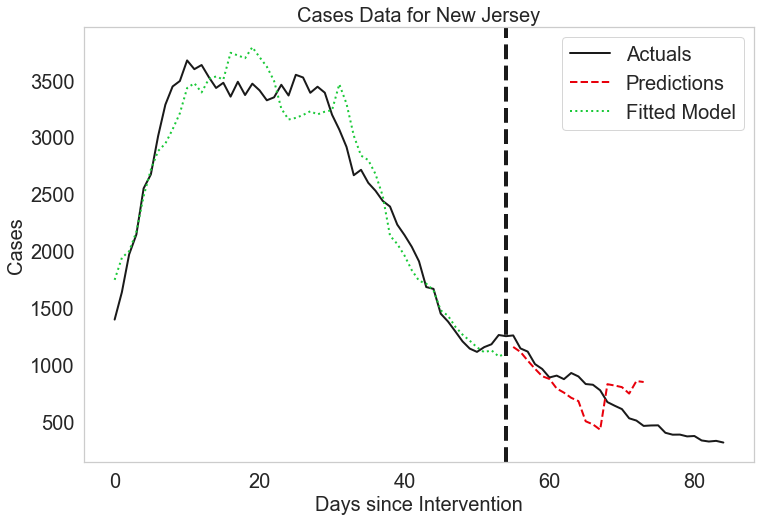

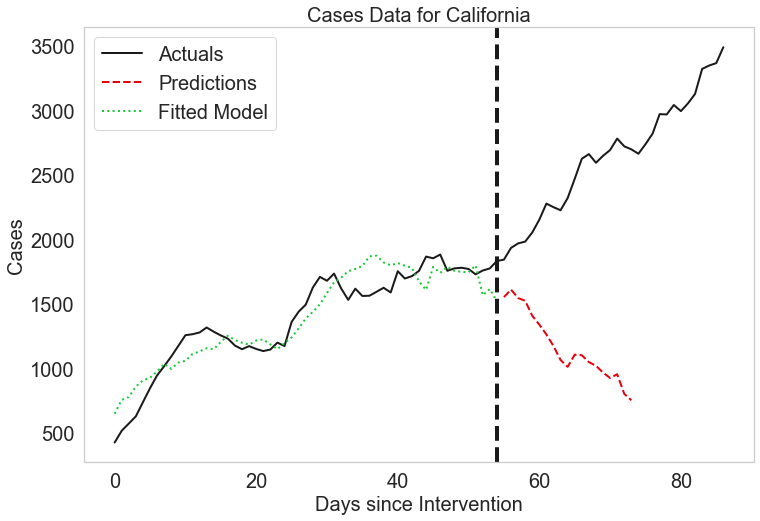

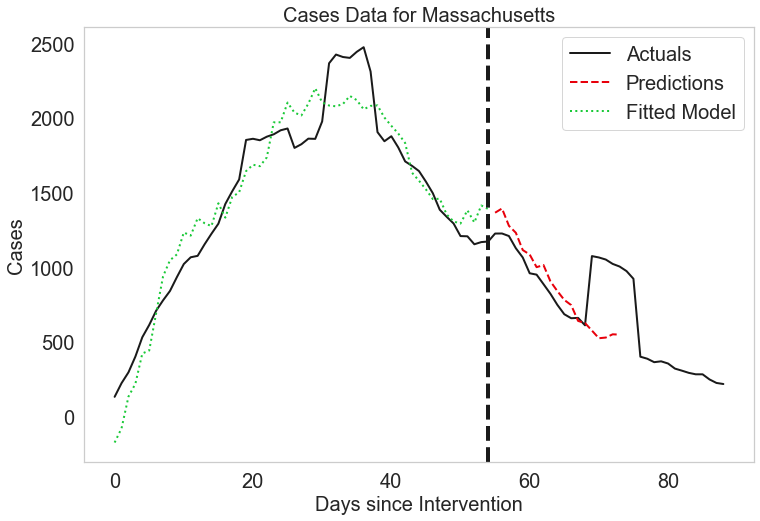

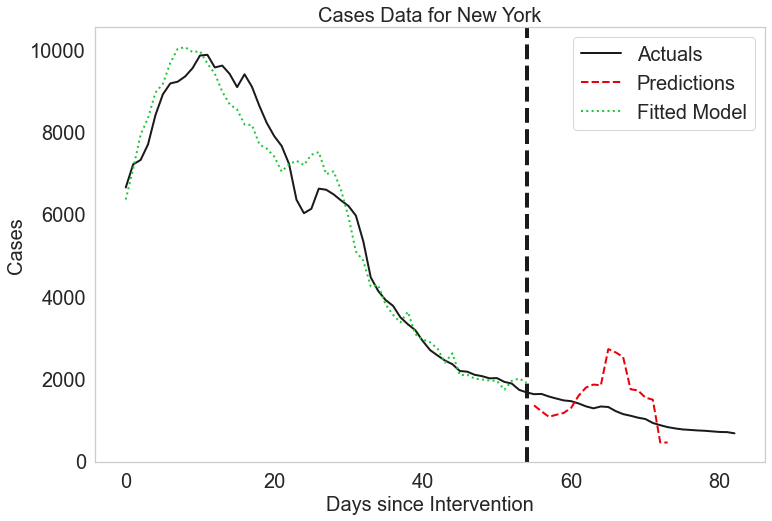

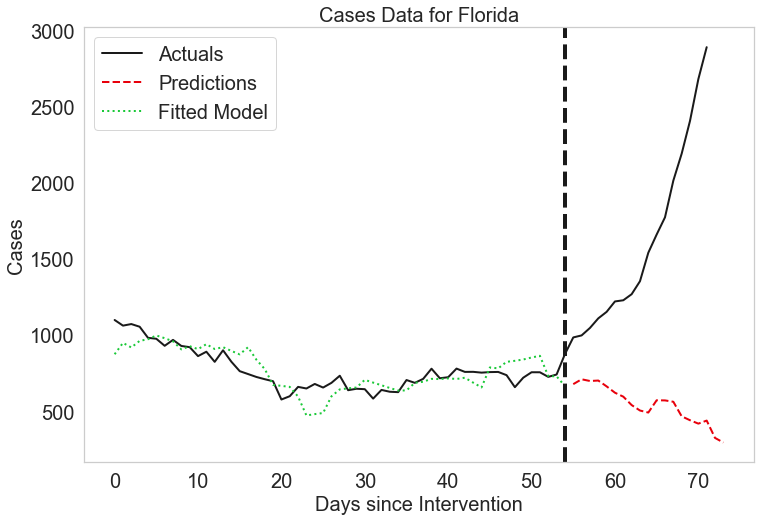

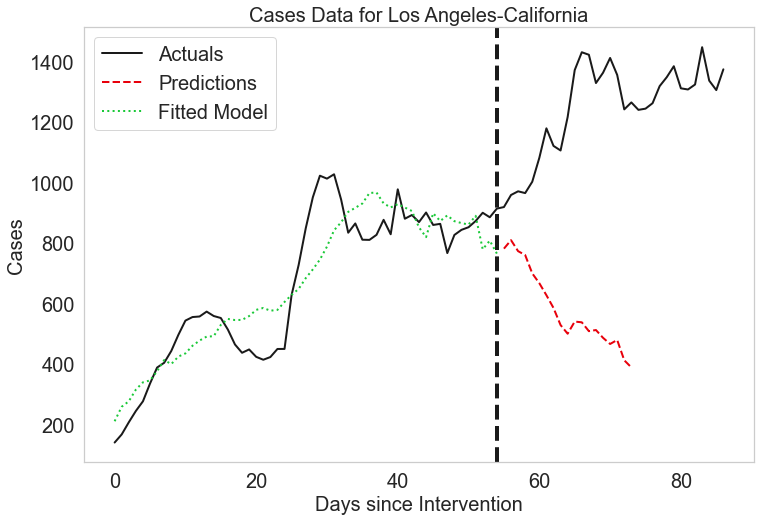

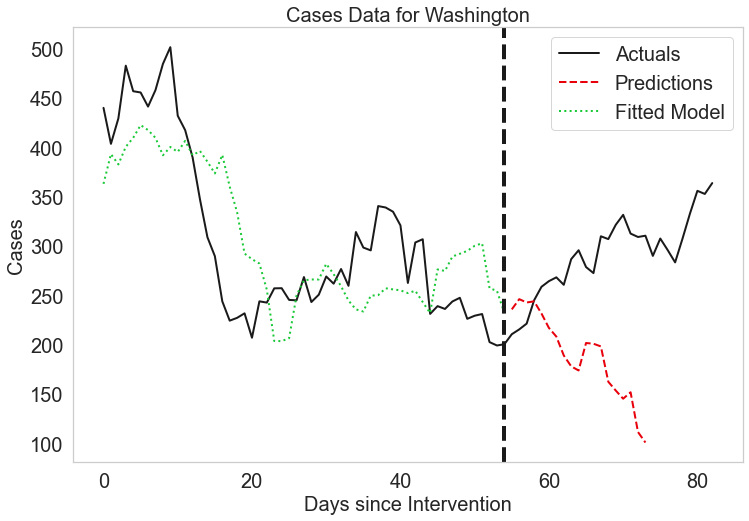

In [41]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()

high_thresh = 80
low_thresh = 55

sizes = df[targets].apply(pd.Series.last_valid_index)
donorpool = sizes[sizes>=high_thresh].index

targets = ['Arizona','Connecticut', 'Texas', 'New Jersey','California', 'Massachusetts',  'New York', 'Florida', 'Los Angeles-California', 'Washington']
donors = ['New York', 'Rhode Island', 'New Jersey', 'Pennsylvania', 'Delaware', 'Connecticut','Michigan', 'Indiana', 'Illinois', 'Massachusetts']

#donors = ['Arizona', 'Florida', 'Texas', 'California', 'Alabama', 'Mississippi', 'New Jersey', 'Pennsylvania', 'Delaware', 'Connecticut']

singVals = 3
weight_features = []
move_intervention = 10
i=1
for target in targets:
  
    try:
        newdata = synth_control_predictions([df1],high_thresh, low_thresh,
                                            "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], donorPool=donors, svdSpectrum=False, silent=True, showDonors=False, showPlots=True, mRSC=False, error_thresh = 10)
        weight_features.append(newdata)
        i=i+1
    except ValueError:
        print(target)
        continue

## Predicting the evolution of cases and deaths in New York based on a western european donor pool

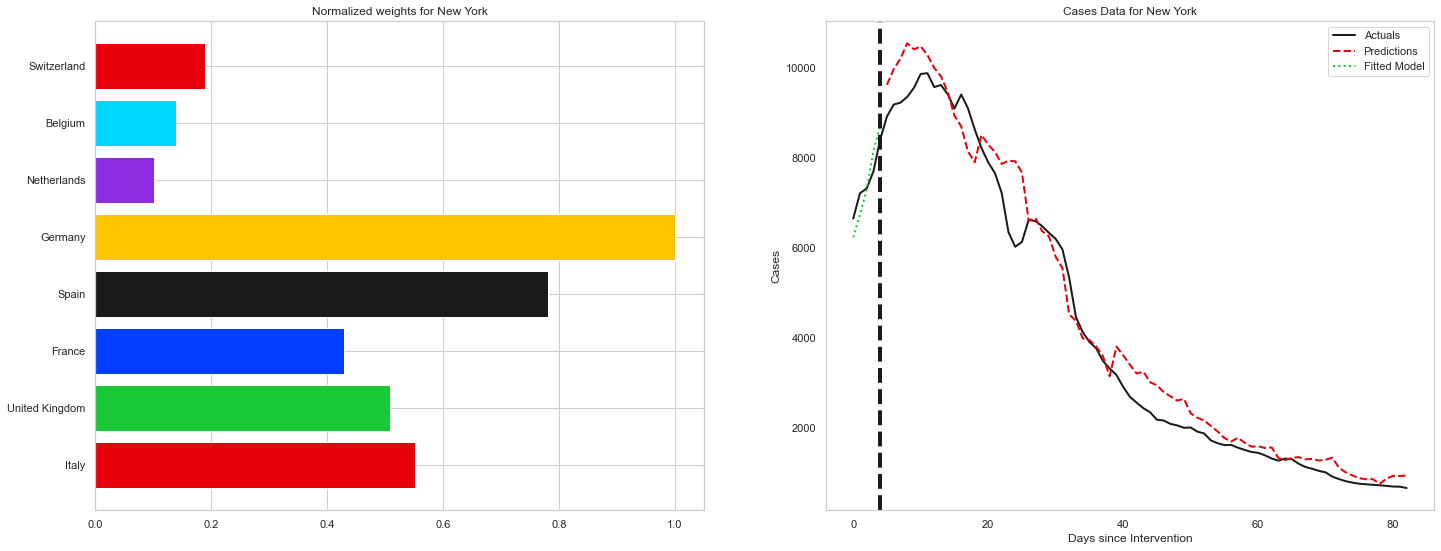

In [17]:
plt.rcParams['figure.figsize'] = (24.0, 9.0)
plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=85
training_period=5
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases Data", 1, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10)

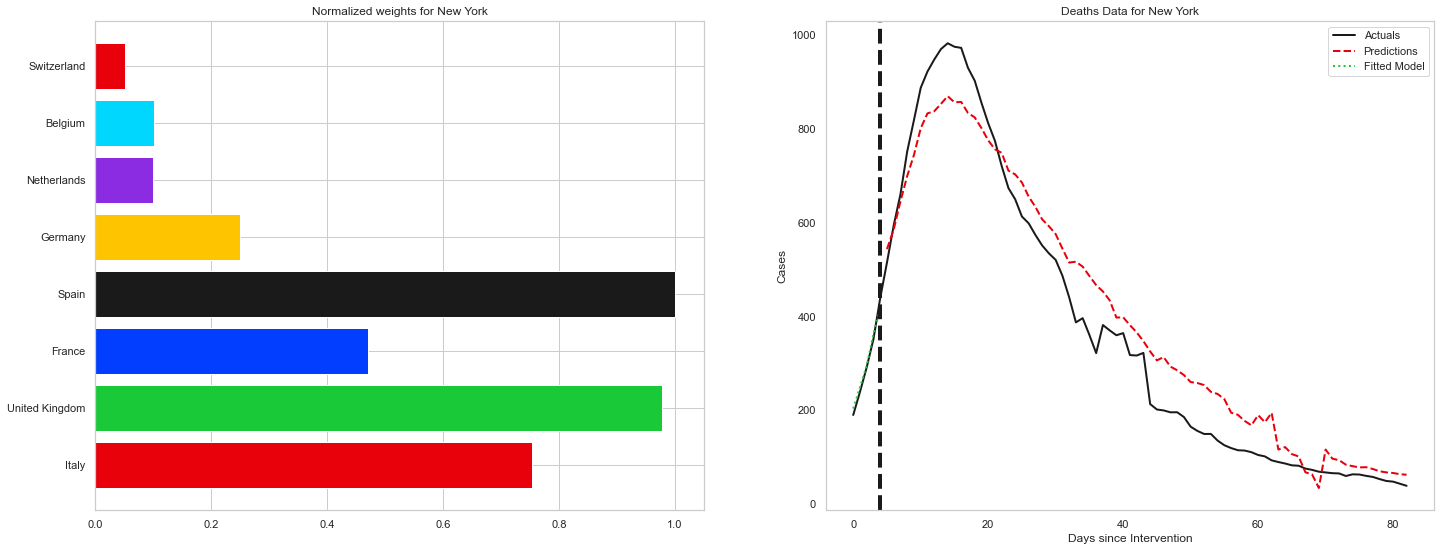

In [18]:
plt.rcParams['figure.figsize'] = (24.0, 9.0)
lambdas = [1, 0.02]
projection_period=85
training_period=5
newdata = synth_control_predictions([df, df1],projection_period, training_period,
                                            "Deaths Data", 1, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10)

## Comparing the evolution of COVID-19 in New York vs the rest of the country

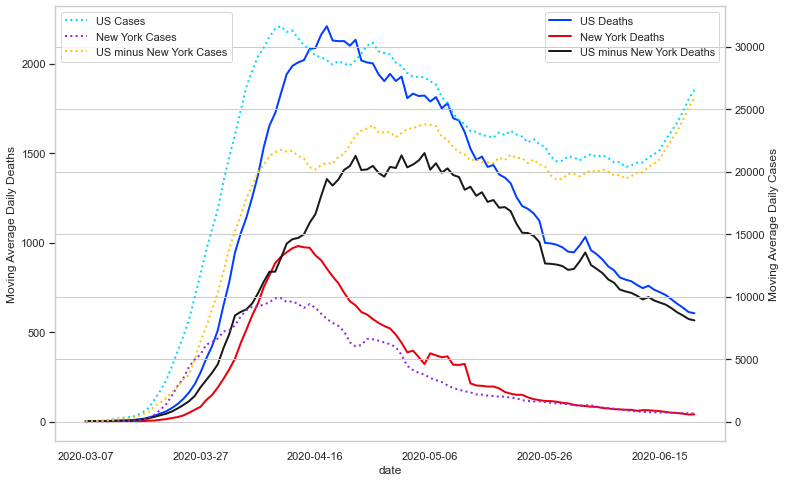

In [44]:
fig, ax = plt.subplots(1,1)

plt.rcParams['figure.figsize'] = (16.0, 9.0)

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Deaths'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York Deaths"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York Deaths"), plt.ylabel('Moving Average Daily Deaths'), plt.legend(loc='upper right')

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(loc='upper left'), plt.ylabel('Moving Average Daily Cases')
plt.show()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()

## Some interesting parallels

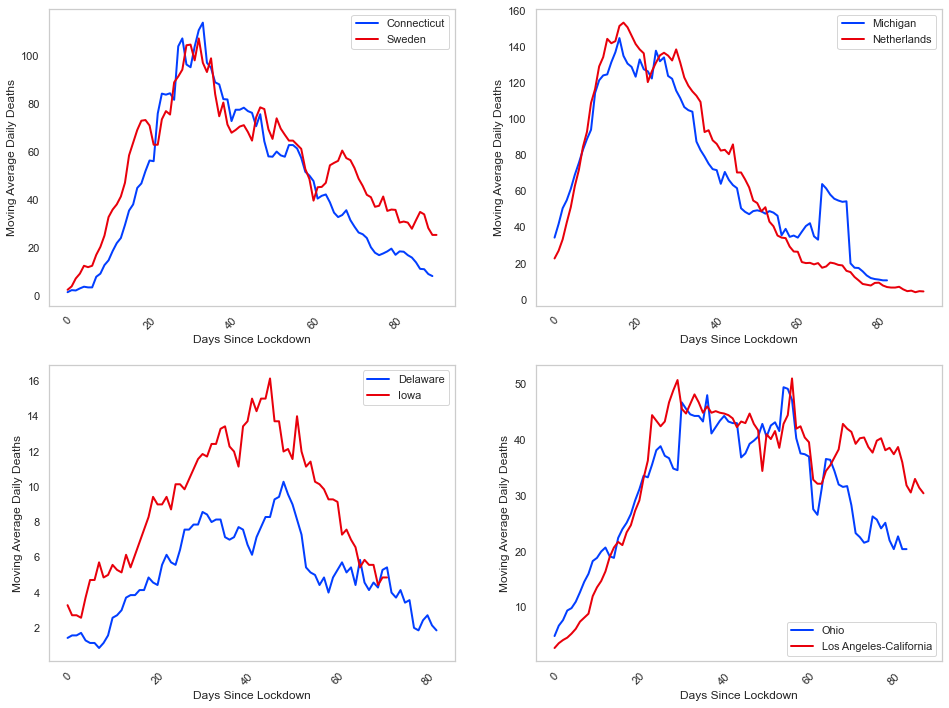

In [28]:

ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden']].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Delaware', 'Iowa']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.show()

## The Sweden herd immunity experiment

(<BarContainer object of 4 artists>, Text(0.5, 0, 'Population'))

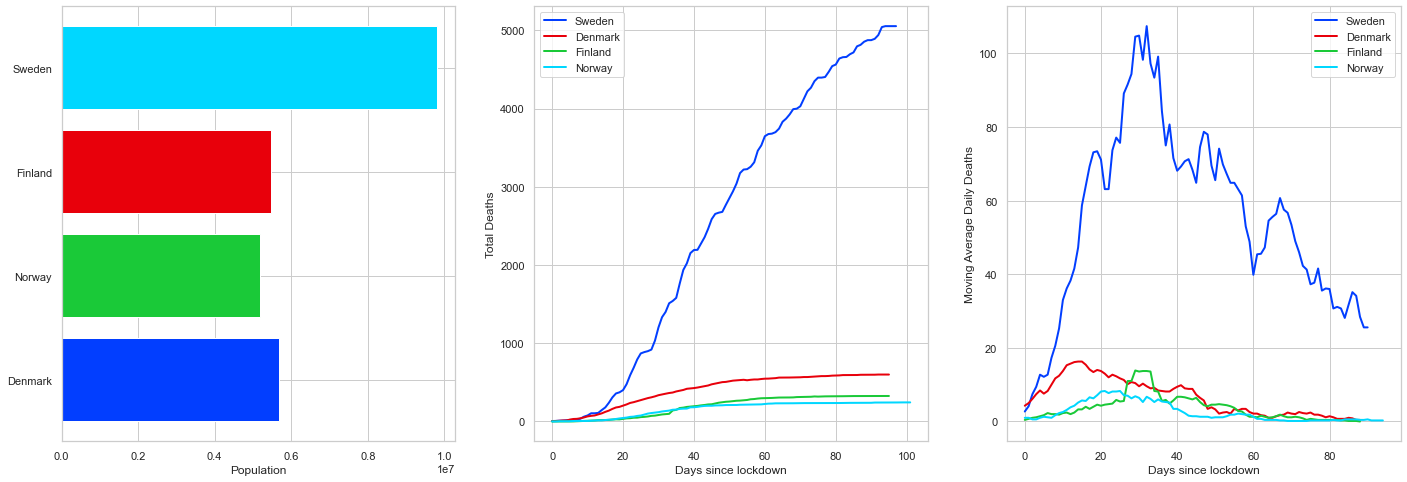

In [37]:
plt.rcParams['figure.figsize'] = (24.0, 8.0)

ax = plt.subplot(1,3,2)
targets = ['Sweden', 'Denmark', 'Finland', 'Norway']
deaths_intervention_adjusted[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Total Deaths')
ax = plt.subplot(1,3,3)

deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Moving Average Daily Deaths')
#plt.show()
ax = plt.subplot(1,3,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')

In [59]:
df = deaths_intervention_adjusted
df1 = cases_intervention_adjusted
targets = ['Sweden']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1, 0.02]
donors = ['Denmark', 'Finland', 'Norway', 'Austria', 'Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland']

for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(5,30):
        return_value = synth_control_predictions([df, df1], 85,i, "7-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=12, donorPool=donors, lambdas=lambdas,
                                   animation = camera, showDonors=False, silent=True, showPlots=True, error_thresh=3)
    animation = camera.animate()

animation.save('Sweden.mp4')
plt.close('all')
HTML(animation.to_html5_video())

## All states cases and deaths at a glance

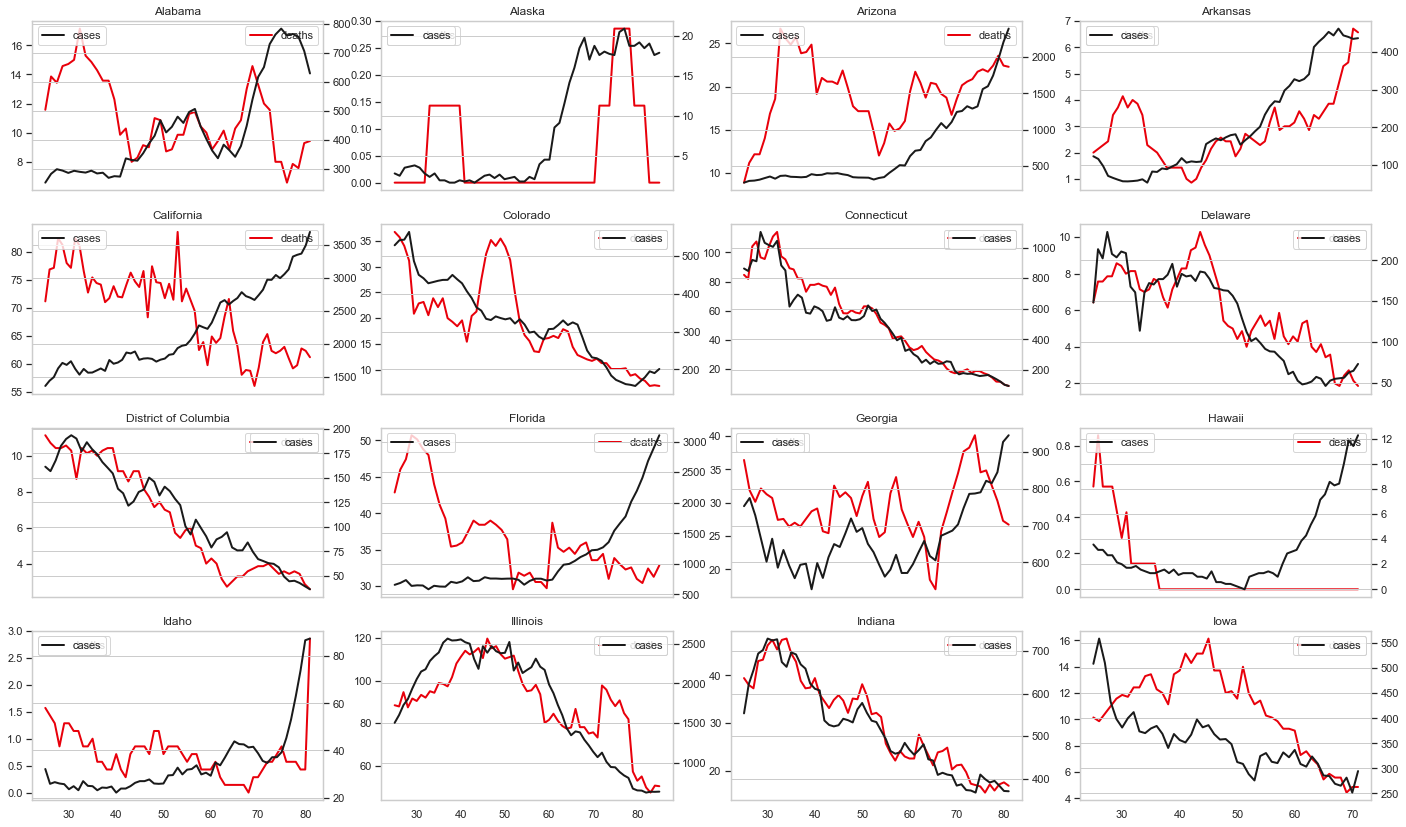

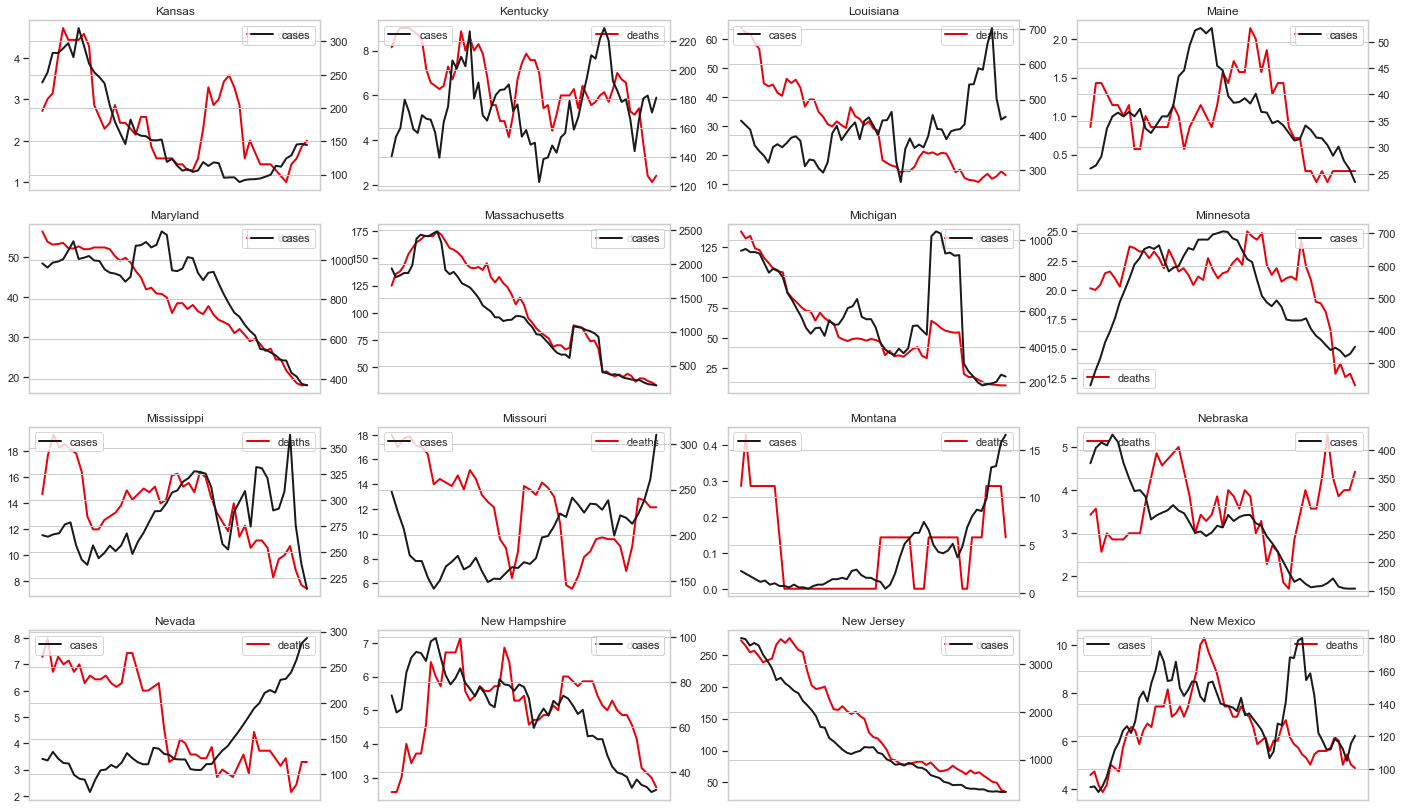

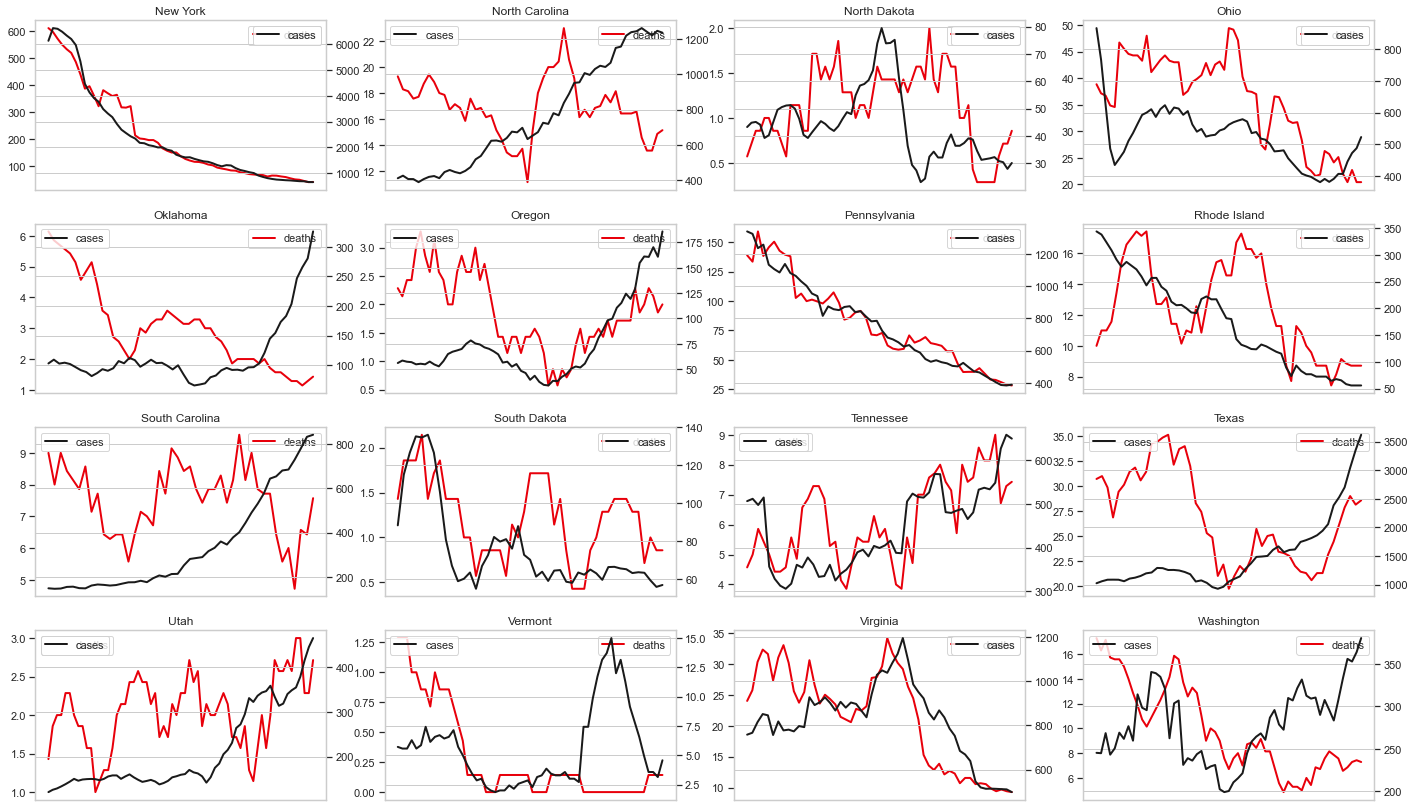

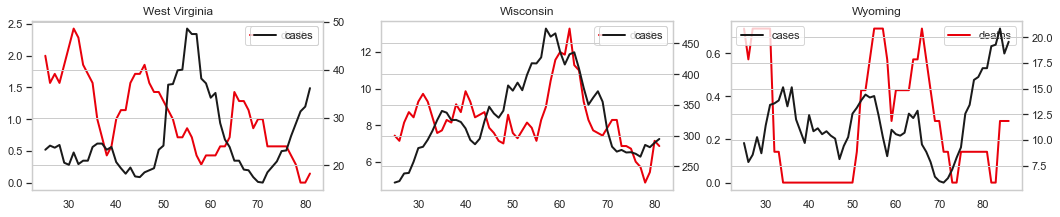

In [20]:
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_us = deaths_intervention_adjusted_daily.columns[deaths_intervention_adjusted_daily.columns.isin(uscases.columns)]
newfig=[16,32,48]

for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths'), plt.legend(loc='best')
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases'), plt.legend(loc='best')
    plt.title(plot_us[i-1])
    if i in newfig:
    
        plt.show()
